# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using LaTeXStrings
@everywhere using Mamba
using Plots
using QuadGK
using StatsBase
using StatsFuns
using StatsPlots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [3]:
df = CSV.read("data/section10a.csv")
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ, 白丸は生存確率0.504の二項分布. 二項分布では観測データのばらつきが説明できていない

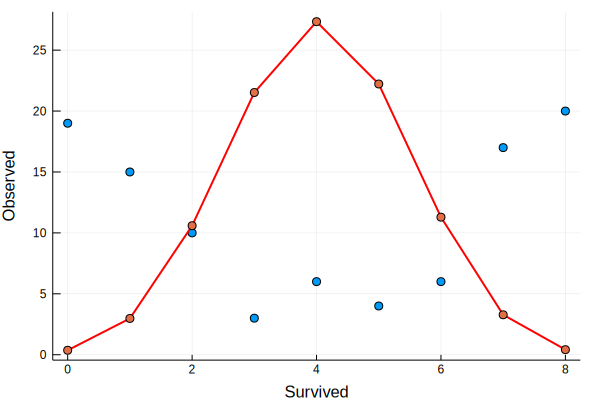

In [4]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor = :red, linewidth = 2,
    marker = 4, label = "",
    xlabel = "Survived", ylabel = "Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング
### モデルの作成
\begin{align}
y_i & \sim \text{Binomial}(q_i, 8) \\
\text{logit}(q_i) & = \beta + r_i \\
\beta & \sim \text{Normal}(0, 100^2) \\
r_i & \sim \text{Normal}(0, \tau^2) \\
\tau & \sim \text{Uniform}(0, 10000)
\end{align}

In [5]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) -> 
            UnivariateDistribution[
                Normal(0, s) for i in 1:N
            ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルの図示

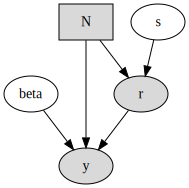

In [6]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [7]:
data = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

### 初期値の設定

In [8]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.0703223, -0.1209, 0.173396, 0.106825, -0.090918, 0.260527, -0.209879, 0.0664417, -0.0260455, 0.0233851  …  -0.0885928, 0.0815617, -0.100917, 0.0908811, -0.0291694, 0.198836, 0.0166497, -0.158106, -0.00193484, -0.0251649])      
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.00227497, 0.0922008, 0.0556108, -0.0355015, 0.0614916, -0.105766, -0.158432, -0.0980073, 0.0786986, 0.00644191  …  0.0596423, -0.0213614, 0.0104238, -0.0529186, -0.104041, 0.0679412, 0.0349163, 0.0332556, -0.0440416, 0.0885477])
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.0177287, -0.0275256, 0.202385, 0.0441925, 0.0633874, -0.0477944, 0.212191, -0.00646067, 0.0160898, -0.0394867  …  -0.0168156, -0.0735346, -0.0770132, 0.0350719, 0.101547, 0.10082, -0.0129551, -0.0500371, 

### MCMCサンプル方法の設定
NUTSを使うと遅くなってしまったので、AMWGを使用

In [9]:
scheme = [
    AMWG(:r, 1),
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                      

### MCMCサンプリング
サンプリングは21000回実施し, burn-inの数は1000, 10飛ばしの結果の記録を3チェイン行うので、サンプルの数は(21000-1000)/10*3=6000個

In [10]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 21000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 21000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [3:27:60 of 3:28:06 remaining]
      From worker 4:	Chain 3:   0% [3:26:04 of 3:26:10 remaining]
      From worker 3:	Chain 2:   0% [3:28:42 of 3:28:48 remaining]
      From worker 2:	Chain 1:  10% [0:04:04 of 0:04:31 remaining]
      From worker 3:	Chain 2:  10% [0:04:08 of 0:04:35 remaining]
      From worker 4:	Chain 3:  10% [0:04:08 of 0:04:36 remaining]
      From worker 2:	Chain 1:  20% [0:03:10 of 0:03:57 remaining]
      From worker 3:	Chain 2:  20% [0:03:13 of 0:04:02 remaining]
      From worker 4:	Chain 3:  20% [0:03:15 of 0:04:03 remaining]
      From worker 2:	Chain 1:  30% [0:02:39 of 0:03:47 remaining]
      From worker 3:	Chain 2:  30% [0:02:42 of 0:03:51 remaining]
      From worker 4:	Chain 3:  30% [0:02:43 of 0:03:52 remaining]
      From worker 2:	Chain 1:  40% [0:02:13 of 0:03:42 remaining]
      From worker 3:	Chain 2:  40% [0:02:16 of 0:03:46 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[2.86305 0.336191; 2.47941 0.298406; … ; 3.16054 0.257474; 3.07941 0.398407]

[3.18629 0.360143; 2.76401 0.234961; … ; 2.66389 -0.158198; 2.83913 -0.123682]

[2.85302 0.397009; 2.73481 -0.166853; … ; 3.04243 0.544018; 2.86048 0.331294]

### サンプリング結果を表示

In [11]:
describe(sim)

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD       Naive SE      MCSE        ESS   
   s 3.038205553 0.36596404 0.004724575 0.0074958665 2000.0000
beta 0.043552525 0.34089301 0.004400910 0.0107590575 1003.8937

Quantiles:
        2.5%       25.0%       50.0%       75.0%      97.5%  
   s  2.3966850  2.78364535 3.007232093 3.26146884 3.82268859
beta -0.6357372 -0.18255441 0.044955688 0.27033841 0.71959967



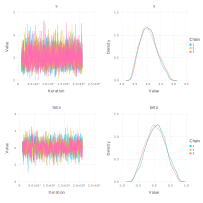

In [12]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

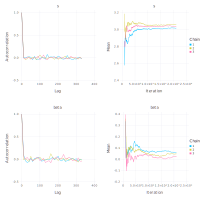

In [13]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

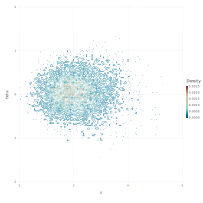

In [14]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow = 1, ncol = 1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測
$p(y \mid \beta, r)p(r \mid s)$を求める関数

In [15]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

$p(y \mid \beta, s) = \int_{-\infty}^\infty p(y \mid \beta, r)p(r \mid s)dr$を求める関数. 
実際は$\int_{-10s}^{10s} p(y \mid \beta, r)p(r \mid s)dr$を求めている

In [16]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

各パスに対し, $y = 0, \ldots, 8$ に対して $p(y \mid \beta, s)$ を評価する.

In [17]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

6000-element Array{Array{Float64,1},1}:
 [0.176316, 0.0997983, 0.0768308, 0.0683657, 0.0669533, 0.0714492, 0.0844603, 0.117662, 0.238164]
 [0.150668, 0.103271, 0.0846313, 0.0773371, 0.0764851, 0.0813768, 0.0943418, 0.124351, 0.207537] 
 [0.186932, 0.121309, 0.0951224, 0.0835864, 0.0795192, 0.0810658, 0.0891174, 0.108564, 0.154784] 
 [0.18602, 0.111099, 0.0857852, 0.0756351, 0.0729111, 0.0760341, 0.0867559, 0.113273, 0.192487]  
 [0.208698, 0.108671, 0.0804124, 0.0696298, 0.0666514, 0.0695804, 0.0802899, 0.108383, 0.207684] 
 [0.167308, 0.0979651, 0.0764672, 0.0686107, 0.0676053, 0.0725085, 0.0860888, 0.120352, 0.243094]
 [0.217999, 0.107979, 0.0787096, 0.067703, 0.0646072, 0.0674065, 0.0779707, 0.106214, 0.21141]   
 [0.227717, 0.103512, 0.0739616, 0.0632475, 0.0603746, 0.0633237, 0.0741535, 0.103986, 0.229725] 
 [0.245183, 0.11364, 0.0804348, 0.0678391, 0.0636934, 0.0654327, 0.074424, 0.0991983, 0.190154]  
 [0.248642, 0.108758, 0.0762036, 0.0642361, 0.0605385, 0.0626669, 0.0722491, 0

各パスに対して、$P(X=y)=p(y \mid \beta, s)\ \text{for}\ y = 0, \ldots, 8$というCategorical distributionから100個体のサンプリングを行い, $y$ごとに出現回数を数える. 横方向は各サンプリング, 縦方向は$y = 0, \ldots, 8$の出現回数に該当

In [18]:
population_samples = hcat(map(x -> fit(Histogram, rand(Distributions.Categorical(x), 100) .- 1, 0:9).weights, posterior)...)

9×6000 Array{Int64,2}:
 21  20  27  16  24  17  23  32  20  …  22  27  25  12  26  36  20  17  15
  7   7  16  13  13   6   9  13  13      7  11   7   6   7  10  15  13   4
 10   8   7   4   8   7   7   9  11      6   8  13  11  10   5   4   9  10
  2   7   4   8   6   8   6   2   4      8   4   6  10   6   8   3   4   5
  8   7  11   9   4   8   9   4   7      8   9   5  10   6   2   7   7   7
  5   8   7   5   8   9   8   5   6  …   9   7   6   1  10   4   8   5   8
  9   7   7  12   8  13   6   4   9     10   7  12   8   9   9   7   6  11
 14  17   4   4   9   8  14  14  12      7  13  10  12  11  10  12  10   9
 24  19  17  29  20  24  18  17  18     23  14  16  30  15  16  24  29  31

$y$毎に出現回数の2.5%, 50%, 97.5%点を計算

In [19]:
function quantile_sample(r)
    map(x -> quantile(population_samples[x, :], r), 1:9)
end
quantile_sample_0025 = quantile_sample(0.025)
quantile_sample_0975 = quantile_sample(0.975)
quantile_sample_median = quantile_sample(0.5)

9-element Array{Float64,1}:
 21.0
 10.0
  8.0
  7.0
  6.0
  7.0
  8.0
 11.0
 22.0

### 生存種子数の予測分布
各 $y$ における中央値, 及び95%区間の領域を表示する

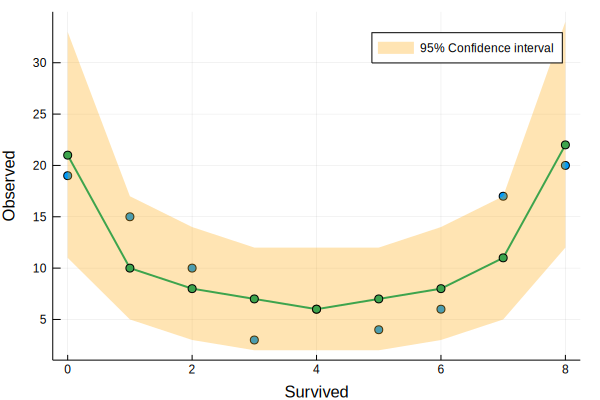

In [20]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
Plots.plot!(0:8, quantile_sample_0025, lw = 0, 
    fillrange = quantile_sample_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
Plots.plot!(0:8, quantile_sample_median, linewidth = 2, marker = 4, label = "",
            xlabel = "Survived", ylabel = "Observed")

## 10.5 個体差 + 場所差の階層ベイズモデル

In [21]:
df2 = CSV.read("data/section10b.csv")
disallowmissing!(df2)

,id,pot,f,y
,Int64,String,String,Int64
1,1,A,C,6
2,2,A,C,3
3,3,A,C,19
4,4,A,C,5
5,5,A,C,0
6,6,A,C,19
7,7,A,C,4
8,8,A,C,8
9,9,A,C,12


In [22]:
marker_dict = Dict(
    "A" => :circle,
    "B" => :ltriangle,
    "C" => :star5,
    "D" => :diamond,
    "E" => :dtriangle,
    "F" => :xcross,
    "G" => :star4,
    "H" => :utriangle,
    "I" => :rect,
    "J" => :rtriangle
)

Dict{String,Symbol} with 10 entries:
  "B" => :ltriangle
  "A" => :circle
  "I" => :rect
  "J" => :rtriangle
  "C" => :star5
  "D" => :diamond
  "G" => :star4
  "E" => :dtriangle
  "F" => :xcross
  "H" => :utriangle

### 個体ごとの表示
赤線は無処理、青線は堆肥処理した個体の平均

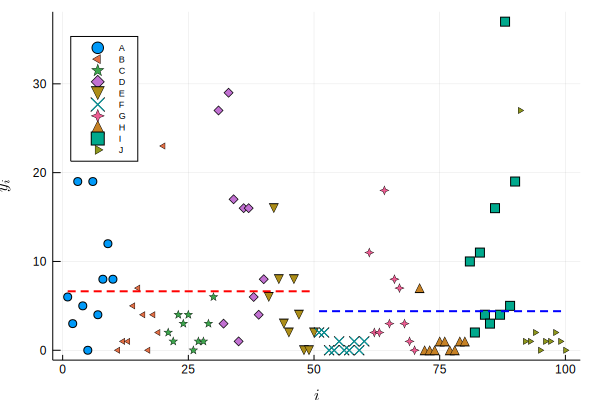

In [23]:
plt = Plots.plot()
for k in sort(collect(keys(marker_dict)))
    df_k = df2[df2[:pot] .== k, :]
    scatter!(df_k.id, df_k.y, label = k, markershape = marker_dict[k],
        legend = :topleft, legendfontsize = 6, xlabel = L"i", ylabel = L"y_i")
end
plot!(1:50, fill(mean(df2[1:50, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :red, label = "")
plot!(51:100, fill(mean(df2[51:100, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :blue, label = "")
plt

### 植木鉢毎に箱ひげ図として図示

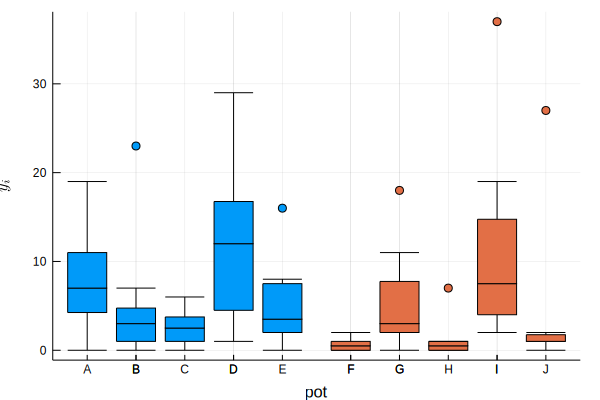

In [24]:
boxplot(df2[1:50, :].pot, df2[1:50, :].y, label = "")
boxplot!(df2[51:100, :].pot, df2[51:100, :].y, label = "", xlabel = "pot", ylabel = L"y_i")

### GLMM化したポアソン回帰
個体$i$の種子数$y_i$を平均$\lambda_i$のポアソン回帰
\begin{align}
p(y_i \mid \lambda_i) = \frac{\lambda_i^{y_i}\exp(-\lambda_i)}{y_i!}
\end{align}
で表現し, 平均種子数は切片$\beta_1$, 堆肥処理の有無を表す因子型の説明変数$f_i$の係数$\beta_2$, 個体$i$の効果$r_i$と植木鉢$j$の効果$t_{j(i)}$で
\begin{align}
\log \lambda_i = \beta_1 + \beta_2 f_i + r_i + t_{j(i)}
\end{align}
で表現.

\begin{align}
y_i & \sim \text{Poisson}(\lambda_i), \ i = 1, \ldots, 100 \\
\log \lambda_i & = \beta_1 + \beta_2 f_i + r_i + t_{j(i)} \\
\beta_1, \beta_2 & \sim \text{Normal}(0, 100) \\
r_i & \sim \text{Normal}(0, s_r^2) \\
t_j & \sim \text{Normal}(0, s_t^2), j = 1,\ldots, 10 \\
s_r, s_t & \sim \text{Uniform}(0, 10000)
\end{align}

In [25]:
model2 = Model(
    
    y = Stochastic(1,
        (beta1, beta2, f, r, t, pot, N_r) ->
            UnivariateDistribution[
                (lambda = exp(beta1 + beta2 * f[i] + r[i] + t[pot[i]]);
                Poisson(lambda)) for i in 1:N_r
            ],
        false
    ),
    
    r = Stochastic(1,
        (s_r, N_r) -> 
            UnivariateDistribution[
                Normal(0, s_r) for i in 1:N_r
            ],
        false
    ),
    
    t = Stochastic(1,
        (s_t, N_t) -> 
            UnivariateDistribution[
                Normal(0, s_t) for i in 1:N_t
            ],
        false
    ),
    
    beta1 = Stochastic(() -> Normal(0, 100)),
    beta2 = Stochastic(() -> Normal(0, 100)),
    
    s_r = Stochastic(() -> Uniform(0, 10000)),
    s_t = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s_r:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s_t:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
t:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarS

### モデルの図示

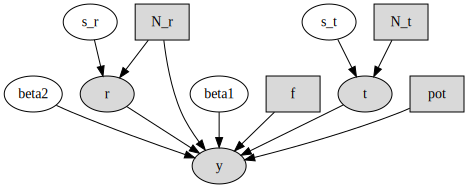

In [26]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model2)))

### 入力データの設定

In [27]:
pot_dict = Dict(string(y) => x for (x, y) in enumerate("ABCDEFGHIJ"))
f_dict = Dict("C" => 0, "T" => 1)
data2 = Dict{Symbol, Any}(
    :y => df2.y,
    :N_r => length(df2.y),
    :N_t => length(unique(df2.pot)),
    :pot => [pot_dict[x] for x in df2.pot],
    :f => [f_dict[x] for x in df2.f],
)

Dict{Symbol,Any} with 5 entries:
  :f   => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  :N_t => 10
  :y   => [6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0]
  :N_r => 100
  :pot => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10,…

### 初期値の設定

In [28]:
inits2 = [
    Dict{Symbol, Any}(
        :y => df2.y,
        :beta1 => 0.0,
        :beta2 => 0.0,
        :r => rand(Normal(0, 0.1), data2[:N_r]),
        :t => rand(Normal(0, 0.1), data2[:N_t]),
        :s_r => 1.0,
        :s_t => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta2=>0.0,:s_r=>1.0,:y=>[6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t=>1.0,:beta1=>0.0,:r=>[-0.0472819, -0.0307922, 0.0303166, 0.0862851, -0.22132, 0.123507, -0.0223637, 0.116535, -0.080678, 0.060361  …  0.0104473, -0.0465903, 0.0436183, 0.0412135, -0.0265958, 0.0216278, 0.0318429, -0.00292399, 0.0656803, -0.0352346],:t=>[0.100402, -0.144901, 0.0501435, -0.0853593, -0.150681, 0.0771974, -0.113421, -0.0532124, 0.136329, -0.0157203])   
 Dict(:beta2=>0.0,:s_r=>1.0,:y=>[6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t=>1.0,:beta1=>0.0,:r=>[-0.0144596, 0.0952292, 0.207384, -0.107736, -0.179719, -0.0741672, -0.0709246, -0.172772, 0.00789308, 0.152458  …  0.0450452, 0.0498585, 0.0357234, 0.0131399, -0.0711505, -0.0305885, 0.0967685, -0.241364, 0.0603498, -0.0621174],:t=>[0.140561, -0.0381306, 0.310753, -0.0370759, -0.206015, 0.00742533, 0.0266539, -0.0623602, 0.0241794, -0.0324043])
 Dict(:beta2=>0

In [29]:
scheme2 = [
    AMWG([:r], 0.1), 
    AMWG([:t], 0.1),
    Slice([:s_r, :s_t], 0.1, Mamba.Univariate), 
    Slice([:beta1, :beta2], 1.0, Mamba.Univariate)
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:t]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, blo

In [30]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data2, inits2, 22000, burnin = 2000, thin = 10, chains = 3)

MCMC Simulation of 22000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [0:10:34 of 0:10:34 remaining]
      From worker 4:	Chain 3:   0% [0:11:11 of 0:11:11 remaining]
      From worker 3:	Chain 2:   0% [0:11:00 of 0:11:01 remaining]
      From worker 2:	Chain 1:  10% [0:03:16 of 0:03:38 remaining]
      From worker 3:	Chain 2:  10% [0:03:20 of 0:03:43 remaining]
      From worker 4:	Chain 3:  10% [0:03:21 of 0:03:43 remaining]
      From worker 2:	Chain 1:  20% [0:02:50 of 0:03:33 remaining]
      From worker 3:	Chain 2:  20% [0:02:54 of 0:03:38 remaining]
      From worker 4:	Chain 3:  20% [0:02:55 of 0:03:39 remaining]
      From worker 2:	Chain 1:  30% [0:02:29 of 0:03:32 remaining]
      From worker 3:	Chain 2:  30% [0:02:32 of 0:03:38 remaining]
      From worker 4:	Chain 3:  30% [0:02:34 of 0:03:40 remaining]
      From worker 2:	Chain 1:  40% [0:02:07 of 0:03:31 remaining]
      From worker 3:	Chain 2:  40% [0:02:10 of 0:03:36 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[-1.44086 1.3278 0.899111 0.986827; -1.30254 1.20649 1.0239 1.10706; … ; -1.1728 1.61224 0.815611 0.845407; -1.22646 1.77763 0.841619 0.976941]

[-0.624271 1.2743 0.978574 1.01151; -0.347753 1.27977 1.07377 1.07833; … ; -0.748752 2.13088 1.19932 0.985965; -0.516964 2.12942 1.3824 0.901813]

[-0.580597 1.40097 0.647985 0.976409; -0.413521 1.04821 0.774076 0.940471; … ; -0.717491 1.87729 1.24831 0.869762; -0.692399 1.61639 1.48877 0.76207]

### 事後分布を確認する
$\beta_2$の95%区間を見ると、堆肥処理の効果はなさそう

In [31]:
describe(sim2)

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE        ESS   
beta2 -0.8316933 0.75306703 0.0097220535 0.0562007440 179.54906
beta1  1.3376949 0.48350070 0.0062419673 0.0378112546 163.51291
  s_t  1.0932100 0.36378343 0.0046964239 0.0286673471 161.03149
  s_r  1.0223158 0.11481484 0.0014822532 0.0043090295 709.96532

Quantiles:
          2.5%       25.0%       50.0%      75.0%      97.5%  
beta2 -2.50799116 -1.27740785 -0.8060195 -0.35999662 0.5901184
beta1  0.43514474  1.01702017  1.3164331  1.63945721 2.3577375
  s_t  0.56078640  0.83607537  1.0336150  1.28451702 1.9615443
  s_r  0.81750476  0.94286034  1.0158008  1.09482976 1.2636193



In [32]:
p = Mamba.plot(sim2, legend = true);

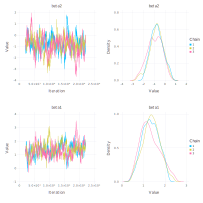

In [33]:
Mamba.draw(p[:, 1:2], nrow = 2, ncol = 2)

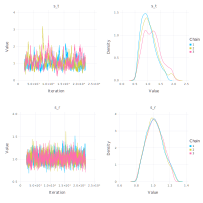

In [34]:
Mamba.draw(p[:, 3:4], nrow = 2, ncol = 2)

In [35]:
p = Mamba.plot(sim2, [:autocor, :mean], legend=true);

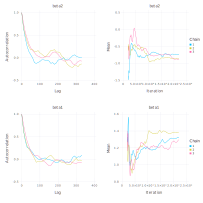

In [36]:
Mamba.draw(p[:, 1:2], nrow = 2, ncol = 2)

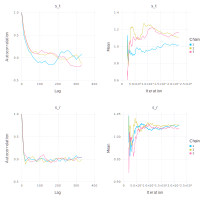

In [37]:
Mamba.draw(p[:, 3:4], nrow = 2, ncol = 2)